## Set Up Dependencies


In [1]:
import datetime
import os

from cliffs_delta import cliffs_delta
import pandas as pd
import pecking
import matplotlib as mpl
from matplotlib import pyplot as plt
import pecking
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp

from pylib._describe_effect import describe_effect
from pylib._styler_to_pdf import styler_to_pdf


## Data Retrieval and Preprocessing


In [2]:
df = pd.read_parquet("https://osf.io/ah7v5/download")


In [3]:
df["Num Reconstructed Inner Nodes"] = df["num_reconstructed_inner_nodes"]
df["Num True Inner Nodes"] = df["num_true_inner_nodes"]
df["Raw Triplet Distance"] = df["triplet_distance_raw"]
df["Sampled Triplet Distance Strict Reconst"] = df[
    "sampled_triplet_distance_strict_reconst"
]
df["Strict Triplet Distance"] = df["sampled_triplet_distance_strict"]
df["Lax Triplet Distance"] = df["sampled_triplet_distance_lax"]
df["Differentia Width (bits)"] = df["differentia_width_bits"]
df["Annotation Size (bits)"] = df["annotation_size_bits"]
df["Algorithm"] = df["algorithm"]
df["Population Size"] = df["population_size"]
df["Num Generations"] = df["num_generations"]
df["Num Islands"] = df["num_islands"]
df["Num Niches"] = df["num_niches"]
df["Tournament Size"] = df["tournament_size"]
df["Replicate"] = df["replicate"]
df["Downsample"] = df["downsample"]


In [4]:
df = df[df["Annotation Size (bits)"] == 256].copy()


In [5]:
df["Inner Node Resolution"] = (
    df["Num Reconstructed Inner Nodes"] / df["Num True Inner Nodes"]
)
df["Inner Node Loss"] = 1 - df["Inner Node Resolution"]


In [6]:
df["Dynamics"] = (
    "islands"
    + df["Num Islands"].astype(str)
    + "-niches"
    + df["Num Niches"].astype(str)
    + "-tsize"
    + df["Tournament Size"].astype(str)
)


In [7]:
df["Scale"] = (
    "npop"
    + df["Population Size"].astype(str)
    + "-ngen"
    + df["Num Generations"].astype(str)
)


In [8]:
df["Scenario"] = df["Dynamics"].map(
    {
        "islands1-niches1-tsize2": "plain",
        "islands1-niches1-tsize1": "drift",
        "islands4-niches2-tsize2": "mild\nstructure",
        "islands64-niches8-tsize2": "rich\nstructure",
    }
)


In [9]:
df["Policy"] = df["Algorithm"].map(
    {
        "surf-tilted": "Tilted",
        "col-tilted": "Tilted",
        "surf-hybrid": "Hybrid",
        "surf-steady": "Steady",
        "col-steady": "Steady",
    }
)


In [10]:
df["Implementation"] = df["Algorithm"].map(
    {
        "surf-tilted": "Surface",
        "col-tilted": "Column",
        "surf-hybrid": "Surface",
        "surf-steady": "Surface",
        "col-steady": "Column",
    }
)


In [11]:
for col in df.columns:
    df[col.replace(" ", "\n")] = df[col]


In [12]:
sensitivity_analysis_variables = [
    "Population\nSize",
    "Downsample",
    "Num\nGenerations",
]


In [13]:
dfx = df.melt(
    id_vars=[
        "Algorithm",
        "Annotation Size (bits)",
        "Annotation\nSize\n(bits)",
        "annotation_size_bits",
        "Differentia Width (bits)",
        "Differentia\nWidth\n(bits)",
        "differentia_width_bits",
        "Downsample",
        "downsample",
        "Dynamics",
        "Implementation",
        "Policy",
        "Scenario",
        "Scale",
        "Population Size",
        "Population\nSize",
        "population_size",
        "Num Generations",
        "Num\nGenerations",
        "num_generations",
        "Num Islands",
        "Num Niches",
        "Tournament Size",
        "Replicate",
    ],
    value_vars=[
        "Strict\nTriplet\nDistance",
        # "Lax\nTriplet\nDistance",
        "Inner\nNode\nLoss",
    ],
)
dfx.head()


,Algorithm,Annotation Size (bits),Annotation\nSize\n(bits),annotation_size_bits,Differentia Width (bits),Differentia\nWidth\n(bits),differentia_width_bits,Downsample,downsample,Dynamics,...,population_size,Num Generations,Num\nGenerations,num_generations,Num Islands,Num Niches,Tournament Size,Replicate,variable,value
0,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,4,Strict\nTriplet\nDistance,1.000000
1,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,12,Strict\nTriplet\nDistance,1.000000
2,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,2,Strict\nTriplet\nDistance,1.000000
3,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,19,Strict\nTriplet\nDistance,0.259036
4,col-steady,256,256,256,8,8,8,500,500,islands4-niches2-tsize2,...,4096,100000,100000,100000,4,2,2,1,Strict\nTriplet\nDistance,1.000000


## Visualize Main Metrics


In [14]:
# for name, group in dfx.groupby(sensitivity_analysis_variables):
#     group_variables = dict(zip(sensitivity_analysis_variables, name))

#     group["Scenario"] = group["Scenario"].apply(
#         lambda x: x.split("\n")[0],
#     )
#     row_order = [
#         "Strict\nTriplet\nDistance",
#         "Lax\nTriplet\nDistance",
#         "Inner\nNode\nLoss",
#     ]

#     tp.tee(
#         pecking.peckplot,
#         data=group.reset_index(drop=True).rename(
#             columns={"Implementation": "Impl"},
#         ),
#         score="value",
#         x="Scenario",
#         y="value",
#         # col="Num Generations",
#         col="Policy",
#         col_order=[
#             "Tilted",
#             "Hybrid",
#             "Steady",
#         ],
#         row="variable",
#         row_order=row_order,
#         hue="Impl",
#         hue_order=[
#             "Column",
#             "Surface",
#         ],
#         x_group="outer",
#         order=[
#             "plain",
#             "mild",
#             "rich",
#             "drift",
#         ],
#         skim_hatches=("*",),
#         skim_labels=("Best",),
#         skimmers=[pecking.skim_lowest],
#         margin_titles=True,
#         height=1.7,
#         aspect=2,
#         facet_kws={
#             "ylim": (0, 1),
#         },
#         teeplot_outattrs={
#             slugify(k): str(v) for k, v in group_variables.items()
#         },
#         teeplot_outexclude="teeplot_postprocess",
#         teeplot_postprocess="teed.figure.subplots_adjust(right=0.72); teed.set_titles(row_template='{row_name}')",
#         # clip_on=False,
#     )
#     display(group_variables)


## Make Stat Table


In [15]:

lookup_effect = {}


def cached_delta(x, y):
    d = cliffs_delta(x, y)[0]
    lookup_effect[d] = describe_effect(x, y)
    return d


vars = [
    "Policy",
    "Scenario",
    *sensitivity_analysis_variables,
]

records = []
for name, group in df[df["Policy"].isin(["Steady", "Tilted", "Hybrid"])].reset_index().groupby(vars):
    group_variables = dict(zip(vars, name))
    records.append(
        {
            **group_variables,
            **{
                "Strict<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Differentia Width (bits)"] == 1][
                        "Strict Triplet Distance"
                    ],
                    group[group["Differentia Width (bits)"] == 8][
                        "Strict Triplet Distance"
                    ],
                ),
                "Lax<br/>Triplet<br/>Distance": cached_delta(
                    group[group["Differentia Width (bits)"] == 1][
                        "Lax Triplet Distance"
                    ],
                    group[group["Differentia Width (bits)"] == 8][
                        "Lax Triplet Distance"
                    ],
                ),
                "Inner<br/>Node<br/>Loss": (
                    cached_delta(
                        group[group["Differentia Width (bits)"] == 1][
                            "Inner Node Loss"
                        ],
                        group[group["Differentia Width (bits)"] == 8][
                            "Inner Node Loss"
                        ],
                    )
                    # if group_variables["Differentia\nWidth\n(bits)"] > 1
                    # else float("nan")
                ),
            },
        }
    )


dfr = pd.DataFrame.from_records(records)
dfr


,Policy,Scenario,Population\nSize,Downsample,Num\nGenerations,Strict<br/>Triplet<br/>Distance,Lax<br/>Triplet<br/>Distance,Inner<br/>Node<br/>Loss
0,Hybrid,drift,4096,500,10000,-0.777500,0.100,-1.0
1,Hybrid,drift,4096,500,100000,-0.647500,0.350,-1.0
2,Hybrid,drift,65536,500,10000,1.000000,0.050,-1.0
3,Hybrid,drift,65536,500,100000,-0.457500,0.200,-1.0
4,Hybrid,drift,65536,8000,10000,1.000000,0.150,-1.0
...,...,...,...,...,...,...,...,...
67,Tilted,rich\nstructure,4096,500,100000,-0.707500,0.225,-1.0
68,Tilted,rich\nstructure,65536,500,10000,-0.027500,0.475,-1.0
69,Tilted,rich\nstructure,65536,500,100000,-0.726875,0.250,-1.0
70,Tilted,rich\nstructure,65536,8000,10000,-0.103750,0.275,-1.0


In [16]:
cmap = mpl.colormaps.get_cmap("coolwarm")
cmap.set_bad(color="white")


In [17]:
dfr["Pop Size"] = dfr["Population\nSize"]
# dfr["Unit"] = dfr["Differentia\nWidth\n(bits)"].map({1: "bit", 8: "byte"})
dfr["DSamp"] = dfr["Downsample"]
# dfr["Size<br/>(bits)"] = dfr["Annotation\nSize\n(bits)"]


In [18]:
vars = [
    "Policy",
    "Scenario",
    # "Unit",
    "Pop Size",
    "DSamp",
    # "Size<br/>(bits)",
]
dfs = (
    dfr[(dfr["Num\nGenerations"] == 100000)]
    .set_index(vars)
    .unstack(level=0)[
        [
            "Strict<br/>Triplet<br/>Distance",
            "Lax<br/>Triplet<br/>Distance",
            "Inner<br/>Node<br/>Loss",
        ]
    ]
    .swaplevel(axis="columns")
    .sort_index(axis=1, level=0, ascending=False)
)
styled_dfs = (
    dfs.style.background_gradient(cmap=cmap, vmin=-1, vmax=1, axis=None)
    .format(lambda x: lookup_effect.get(x, "n/a"))
)

props = [
    ("cellpadding", "0px"),
    ("cellspacing", "0px"),
    ("border", "1px solid black"),
    ("border-collapse", "collapse"),
    ("max-width", "80px !important"),
    ("word-wrap", "break-word"),
]
moreprops = [
    *props,
    ("padding-top", "0px"),
    ("padding-bottom", "0px"),
    ("margin", "0px"),
    ("height", "0px"),
]
smallprops = [*moreprops, ("font-size", "9px"), ("text-align", "center"), ("width", "75px")]
bigprops = [
    *moreprops,
    ("font-size", "11px"),
    ("color", "white"),
    ("background-color", "DimGray"),
]

divider_style = [
    # Header cell borders
    {"selector": "th", "props": bigprops},
    # Data cell borders
    {"selector": "td", "props": smallprops},
    # Row borders
    {"selector": "tr", "props": smallprops},
]
styled_dfs = styled_dfs.set_table_styles(divider_style).set_table_attributes(
    'style="cellspacing:0;border-collapse:collapse;font-family:sans-serif;"'
)

styled_dfs


In [19]:
os.makedirs("outplots", exist_ok=True)
styler_to_pdf(styled_dfs, "outplots/bit-vs-byte-table.pdf")


inkscape output:
 
** (inkscape:6301): WARNING **: 16:45:27.691: No pages selected, getting first page only.

** (inkscape:6301): WARNING **: 16:45:27.965: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.



## Make Table Summarization


In [20]:
import numpy as np

dfp = dfs.stack(level=0).reset_index().copy()
dfp["Strict Triplet Distance"] = dfp["Strict<br/>Triplet<br/>Distance"].apply(
    lambda x: {
        -1: "bit-width better",
        0: "neutral",
        1: "byte-width better",
    }[
        ("*" in lookup_effect.get(x))
        * np.sign(x)
    ],
)
dfp["Lax Triplet Distance"] = dfp["Lax<br/>Triplet<br/>Distance"].apply(
    lambda x: {
        -1: "bit-width better",
        0: "neutral",
        1: "byte-width better",
    }[
        ("*" in lookup_effect.get(x))
        * np.sign(x)
    ],
)
dfp["Inner Node Loss"] = dfp["Inner<br/>Node<br/>Loss"].apply(
    lambda x: {
        -1: "bit-width better",
        0: "neutral",
        1: "byte-width better",
    }[
        ("*" in lookup_effect.get(x))
        * np.sign(x)
    ],
)
dfp


,Scenario,Pop Size,DSamp,Policy,Inner<br/>Node<br/>Loss,Lax<br/>Triplet<br/>Distance,Strict<br/>Triplet<br/>Distance,Strict Triplet Distance,Lax Triplet Distance,Inner Node Loss
0,drift,4096,500,Hybrid,-1.00000,0.350000,-0.647500,bit-width better,byte-width better,bit-width better
1,drift,4096,500,Steady,-1.00000,0.697500,-0.711250,bit-width better,byte-width better,bit-width better
2,drift,4096,500,Tilted,-1.00000,0.300000,-0.663125,bit-width better,byte-width better,bit-width better
3,drift,65536,500,Hybrid,-1.00000,0.200000,-0.457500,bit-width better,byte-width better,bit-width better
4,drift,65536,500,Steady,-1.00000,0.151875,-0.284375,bit-width better,byte-width better,bit-width better
5,drift,65536,500,Tilted,-1.00000,0.400000,-0.713750,bit-width better,byte-width better,bit-width better
6,drift,65536,8000,Hybrid,-1.00000,0.140000,-0.650000,bit-width better,neutral,bit-width better
7,drift,65536,8000,Steady,-1.00000,0.125000,-0.418125,bit-width better,byte-width better,bit-width better
8,drift,65536,8000,Tilted,-1.00000,0.398125,-0.691875,bit-width better,byte-width better,bit-width better
9,mild\nstructure,4096,500,Hybrid,-1.00000,0.500000,-0.695000,bit-width better,byte-width better,bit-width better


In [21]:
dfp = dfp.rename(
    columns={
        "Inner<br/>Node<br/>Loss": "Inner Node Loss Numerical",
        "Strict<br/>Triplet<br/>Distance": "Strict Triplet Distance Numerical",
        "Lax<br/>Triplet<br/>Distance": "Lax Triplet Distance Numerical",
    },
)


In [22]:
id_vars = [
    "Policy",
    "Scenario",
    # "Unit",
    "Pop Size",
    "DSamp",
    # "Num Generations",
    # "Size<br/>(bits)",
]
dfm = pd.DataFrame.merge(
    dfp.melt(
        id_vars=id_vars,
        value_vars=[
            "Strict Triplet Distance",
            "Lax Triplet Distance",
            "Inner Node Loss",
        ],
    ),
    dfp.melt(
        id_vars=id_vars,
        value_vars=[
            "Strict Triplet Distance Numerical",
            "Lax Triplet Distance Numerical",
            "Inner Node Loss Numerical",
        ],
    ),
    on=id_vars,
)


In [23]:
dfm = dfm[
    (
        dfm["variable_x"].isin(["Strict Triplet Distance"])
        & dfm["variable_y"].isin(["Strict Triplet Distance Numerical"])
    )
    | (
        dfm["variable_x"].isin(["Lax Triplet Distance"])
        & dfm["variable_y"].isin(["Lax Triplet Distance Numerical"])
    )
    | (
        dfm["variable_x"].isin(["Inner Node Loss"])
        & dfm["variable_y"].isin(["Inner Node Loss Numerical"])
    )
].reset_index()


In [24]:
dfm["Scenario"] = dfm["Scenario"].apply(lambda x: x.split("\n")[0])


teeplots/col=metric+hue=relative-grade+kind=strip+row=policy+viz=catplot+x=cliff-s-delta+y=scenario+ext=.pdf


teeplots/col=metric+hue=relative-grade+kind=strip+row=policy+viz=catplot+x=cliff-s-delta+y=scenario+ext=.png


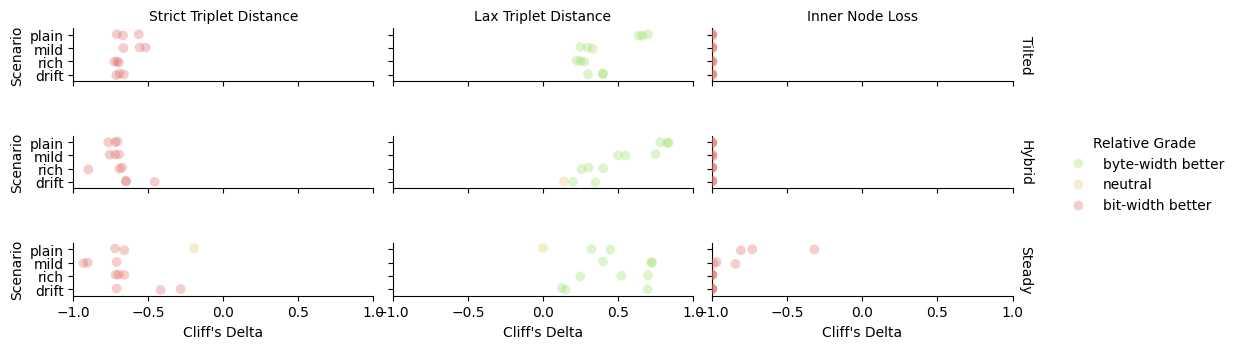

In [25]:
tp.tee(
    sns.catplot,
    dfm.rename(
        {
            "variable_x": "Metric",
            "value_y": "Cliff's Delta",
            "value_x": "Relative Grade",
        },
        axis=1,
    ),
    x="Cliff's Delta",
    # y="Policy",
    row="Policy",
    row_order=["Tilted", "Hybrid", "Steady"],
    order=[
        "plain",
        "mild",
        "rich",
        "drift",
    ],
    hue="Relative Grade",
    hue_order=[
        "byte-width better",
        "neutral",
        "bit-width better",
    ],
    col="Metric",
    # row="Scenario",
    y="Scenario",
    margin_titles=True,
    aspect=3,
    height=1.2,
    palette=sns.color_palette("hls", 8)[:3][::-1],
    alpha=0.3,
    s=50,
    kind="strip",
    teeplot_postprocess="teed.set_titles(col_template='{col_name}', row_template='{row_name}'); teed.set(xlim=(-1, 1));",
    teeplot_outexclude="post",
)
plt.show()


## Reproducibility


In [26]:
datetime.datetime.now().isoformat()


'2024-09-30T16:45:31.275886'

In [27]:
%load_ext watermark
%watermark


Last updated: 2024-09-30T16:45:31.289179+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1014-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [28]:
!pip freeze


alifedata-phyloinformatics-convert==0.16.2
annotated-types==0.6.0
anytree==2.12.1
appdirs==1.4.4
argcomplete==3.5.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
asttokens==2.4.1
attrs==23.2.0
Automat==20.2.0
Babel==2.8.0
backstrip==0.2.4
bcrypt==3.2.0
beautifulsoup4==4.12.3
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
black==22.10.0
bleach==6.1.0
blinker==1.4
Brotli==1.1.0
CacheControl==0.12.10
certifi==2024.2.2
cffi==1.16.0
chardet==4.0.0
charset-normalizer==3.3.2
click==8.1.7
cliffs-delta==1.0.0
cloud-init==24.2
colorama==0.4.4
colorclade==0.2.0
comm==0.2.1
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.0
cryptography==3.4.8
cssselect==1.1.0
cssselect2==0.7.0
cycler==0.12.1
dataclasses==0.6
dbus-python==1.2.18
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
distro==1.7.0
distro-info==1.1+ubuntu0.2
distutils-strtobool==0.1.0
entrypoints==0.4
ete3==3.1.3
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1

In [29]:
!inkscape --version


Inkscape 1.3.2 (1:1.3.2+202311252150+091e20ef0f)
